# Visualize Nashville Building Permit Data related to storm damage

###### Imports and Defaults

In [2]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from warnings import simplefilter
import numpy as np
from shapely.geometry import Point
from shapely.geometry import shape
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

simplefilter("ignore")  # ignore warnings to clean up output cells

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

## API Call for time and point

Create your API call through the SODA API by creating a variable called *endpoint* and a dictionary of *parameters* that can both include the columns you want and filters by whatever columns you want. Here I want all of the data, but I don't need every column. The API Guide can be found here:

https://dev.socrata.com/foundry/data.nashville.gov/3h5w-q8b7

In [4]:
#endpoint variable
endpoint = 'https://data.nashville.gov/resource/3h5w-q8b7.json'

In [5]:
#the only params we need are the columns, I want the ivr_trk as the unique id, type and subtype description, date issued, value of construction, 
#address, zip, council district, purpose, mapped location
#also set the limit high so the downloads don't cut off
params = {'$select': 'council_dist, permit_type_description, permit_subtype_description, date_issued, const_cost, address, purpose, mapped_location', 
          '$q': 'storm', 
          '$limit': 50000}
response = requests.get(endpoint, params = params)
response.status_code

200

In [6]:
data = response.json()
data = pd.DataFrame(data)
print(data.shape)
data.head(3)

(731, 8)


council_dist                  permit_type_description  \
0           26  Building Residential Rehab Storm Damage   
1           12     Building Commercial New Storm Damage   
2           26        Building Residential - Foundation   

    permit_subtype_description              date_issued const_cost  \
0      Single Family Residence  2021-06-21T00:00:00.000      40000   
1  Accessory Structure, Garage  2021-05-05T00:00:00.000     106852   
2      Single Family Residence  2021-09-17T00:00:00.000      30000   

                   address                                            purpose  \
0           5045  SUTER DR  to conduct general repairs to existing residen...   
1  5610B  OLD HICKORY BLVD  Rebuilding due to storm Damage, no change to f...   
2          4818  MILNER DR  to rehab and elevate flood damaged foundation ...   

                                     mapped_location  
0  {'latitude': '36.068916', 'longitude': '-86.73...  
1  {'latitude': '36.177939', 'longitude': '-86.60...  
2  {'latitude': '36.074775', 'longitude': '-86.73...

## Data Cleaning, Create Geodataframe for Point data

Rename columns

In [7]:
data.columns = ['dist','type','subtype','date','cost','address','purpose','location']

In [8]:
data.dropna()

dist                                     type  \
0     26  Building Residential Rehab Storm Damage   
1     12     Building Commercial New Storm Damage   
2     26        Building Residential - Foundation   
3     26  Building Residential Rehab Storm Damage   
4      4               Building Demolition Permit   
..   ...                                      ...   
726   19     Building Commercial New Storm Damage   
727   15    Building Residential New Storm Damage   
728   14  Building Residential Rehab Storm Damage   
729   18  Building Residential Rehab Storm Damage   
730   26          Building Residential - Addition   

                                      subtype                     date  \
0                     Single Family Residence  2021-06-21T00:00:00.000   
1                 Accessory Structure, Garage  2021-05-05T00:00:00.000   
2                     Single Family Residence  2021-09-17T00:00:00.000   
3                     Single Family Residence  2021-06-21T00:00:00.000   
4             Demolition Permit - Residential  2021-05-07T00:00:00.000   
..                                        ...                      ...   
726  Multifamily, Apt / Twnhome > 5 Unit Bldg  2020-04-28T00:00:00.000   
727               Accessory Structure, Garage  2021-04-15T00:00:00.000   
728                   Single Family Residence  2020-05-06T00:00:00.000   
729    Multifamily, Condominium > 5 Unit Bldg  2021-04-20T00:00:00.000   
730                   Single Family Residence  2020-06-17T00:00:00.000   

        cost                  address  \
0      40000           5045  SUTER DR   
1     106852  5610B  OLD HICKORY BLVD   
2      30000          4818  MILNER DR   
3      89000   224  ELYSIAN FIELDS RD   
4      10000      808  CLOVERFIELD CT   
..       ...                      ...   
726  2003000          515  MADISON ST   
727     2360     2232B  MAPLECREST DR   
728   130000           204  DEDHAM DR   
729   100000       2201  PORTLAND AVE   
730    60000         5308  OVERTON RD   

                                               purpose  \
0    to conduct general repairs to existing residen...   
1    Rebuilding due to storm Damage, no change to f...   
2    to rehab and elevate flood damaged foundation ...   
3    Replace floors, replace hvac and ductwork, rep...   
4    Remove storm damaged structure (home) above th...   
..                                                 ...   
726  reconstruct and repair from tornado storm dama...   
727  To replace 19'x20' carport damaged by March 3,...   
728  New roof. Minor interior repairs. Rebuild elec...   
729  Roof & Gutter Replacement, Flat roof - TPO 60 ...   
730  Self Permit, personal residence. 3 additions t...   

                                              location  
0    {'latitude': '36.068916', 'longitude': '-86.73...  
1    {'latitude': '36.177939', 'longitude': '-86.60...  
2    {'latitude': '36.074775', 'longitude': '-86.73...  
3    {'latitude': '36.092995', 'longitude': '-86.71...  
4    {'latitude': '36.026177', 'longitude': '-86.76...  
..                                                 ...  
726  {'latitude': '36.175017', 'longitude': '-86.78...  
727  {'latitude': '36.177612', 'longitude': '-86.69...  
728  {'latitude': '36.183634', 'longitude': '-86.64...  
729  {'latitude': '36.133374', 'longitude': '-86.80...  
730  {'latitude': '36.058632', 'longitude': '-86.76...  

[731 rows x 8 columns]

Let's check out location, it appears to be a dictionary

In [9]:
type(data['location'][0])

dict

Use a lambda function to....?

In [10]:
data['location'].head().apply(lambda x: x['latitude'])

0    36.068916
1    36.177939
2    36.074775
3    36.092995
4    36.026177
Name: location, dtype: object

You come up against issues if some of the data doesn't have the location in there, so we're gonna create an empty list and use a for loop to find these rows

In [11]:
no_lat = []
for ind, val in data['location'].iteritems():
    try:
        val['latitude']
    except:
        print(ind, val)
        no_lat.append(ind)

21 {'human_address': '{"address": "3510 HILLDALE DR", "city": "NASHVILLE", "state": "TN", "zip": "37215"}'}
77 {'human_address': '{"address": "221 REP JOHN LEWIS WAY N", "city": "NASHVILLE", "state": "TN", "zip": "37219"}'}
82 {'human_address': '{"address": "1607B COUNTY HOSPITAL RD MIDDLE / S", "city": "NASHVILLE", "state": "TN", "zip": "37218"}'}
157 {'human_address': '{"address": "98 N 8TH ST", "city": "NASHVILLE", "state": "TN", "zip": "37206"}'}
702 {'human_address': '{"address": "98 N 8TH ST", "city": "NASHVILLE", "state": "TN", "zip": "37206"}'}


In [12]:
len(no_lat)

5

In [13]:
data = data.drop(no_lat)

In [14]:
data['lat'] = data['location'].apply(lambda x: x['latitude'])

In [15]:
data['lon'] = data['location'].apply(lambda x: x['longitude'])

In [16]:
data.head(3)

dist                                     type                      subtype  \
0   26  Building Residential Rehab Storm Damage      Single Family Residence   
1   12     Building Commercial New Storm Damage  Accessory Structure, Garage   
2   26        Building Residential - Foundation      Single Family Residence   

                      date    cost                  address  \
0  2021-06-21T00:00:00.000   40000           5045  SUTER DR   
1  2021-05-05T00:00:00.000  106852  5610B  OLD HICKORY BLVD   
2  2021-09-17T00:00:00.000   30000          4818  MILNER DR   

                                             purpose  \
0  to conduct general repairs to existing residen...   
1  Rebuilding due to storm Damage, no change to f...   
2  to rehab and elevate flood damaged foundation ...   

                                            location        lat         lon  
0  {'latitude': '36.068916', 'longitude': '-86.73...  36.068916  -86.738966  
1  {'latitude': '36.177939', 'longitude': '-86.60...  36.177939  -86.604593  
2  {'latitude': '36.074775', 'longitude': '-86.73...  36.074775  -86.733314

In [17]:
len(data)

726

In [18]:
data = data.drop(columns = ['location'])

In [19]:
data['geometry'] = data.apply(lambda x: Point((float(x.lon), 
                                              float(x.lat))), axis = 1)
data.head(3)

dist                                     type                      subtype  \
0   26  Building Residential Rehab Storm Damage      Single Family Residence   
1   12     Building Commercial New Storm Damage  Accessory Structure, Garage   
2   26        Building Residential - Foundation      Single Family Residence   

                      date    cost                  address  \
0  2021-06-21T00:00:00.000   40000           5045  SUTER DR   
1  2021-05-05T00:00:00.000  106852  5610B  OLD HICKORY BLVD   
2  2021-09-17T00:00:00.000   30000          4818  MILNER DR   

                                             purpose        lat         lon  \
0  to conduct general repairs to existing residen...  36.068916  -86.738966   
1  Rebuilding due to storm Damage, no change to f...  36.177939  -86.604593   
2  to rehab and elevate flood damaged foundation ...  36.074775  -86.733314   

                               geometry  
0          POINT (-86.738966 36.068916)  
1  POINT (-86.60459299999999 36.177939)  
2  POINT (-86.73331399999999 36.074775)

## API Call for City Council GIS outlines for polygon data

In [20]:
endpoint = 'https://data.nashville.gov/resource/iw7r-m8qr.json'

In [21]:
params = {'$select': 'boundary, council_district'}
response = requests.get(endpoint, params = params)
response.status_code

200

In [22]:
geo = response.json()
geo = pd.DataFrame(geo)
print(geo.shape)
geo.head(3)

(35, 2)


boundary council_district
0  {'type': 'MultiPolygon', 'coordinates': [[[[-8...                1
1  {'type': 'MultiPolygon', 'coordinates': [[[[-8...                2
2  {'type': 'MultiPolygon', 'coordinates': [[[[-8...                3

The geographic information is all nested in there, so we'll use the shape function to bring it out

In [23]:
geo['geometry'] = geo['boundary'].apply(shape)

In [24]:
geo.head(3)

boundary council_district  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[-8...                1   
1  {'type': 'MultiPolygon', 'coordinates': [[[[-8...                2   
2  {'type': 'MultiPolygon', 'coordinates': [[[[-8...                3   

                                            geometry  
0  (POLYGON ((-86.90738248774343 36.3905151283193...  
1  (POLYGON ((-86.75902399986667 36.2309080000732...  
2  (POLYGON ((-86.76841900029567 36.3835789999444...

In [25]:
geo = geo.drop(columns = 'boundary')

### Make the points into its own geodataframe

In [26]:
point = gpd.GeoDataFrame(data, 
                           crs = 4326, 
                           geometry = data['geometry'])

In [27]:
point.head()

dist                                     type  \
0   26  Building Residential Rehab Storm Damage   
1   12     Building Commercial New Storm Damage   
2   26        Building Residential - Foundation   
3   26  Building Residential Rehab Storm Damage   
4    4               Building Demolition Permit   

                           subtype                     date    cost  \
0          Single Family Residence  2021-06-21T00:00:00.000   40000   
1      Accessory Structure, Garage  2021-05-05T00:00:00.000  106852   
2          Single Family Residence  2021-09-17T00:00:00.000   30000   
3          Single Family Residence  2021-06-21T00:00:00.000   89000   
4  Demolition Permit - Residential  2021-05-07T00:00:00.000   10000   

                   address                                            purpose  \
0           5045  SUTER DR  to conduct general repairs to existing residen...   
1  5610B  OLD HICKORY BLVD  Rebuilding due to storm Damage, no change to f...   
2          4818  MILNER DR  to rehab and elevate flood damaged foundation ...   
3   224  ELYSIAN FIELDS RD  Replace floors, replace hvac and ductwork, rep...   
4      808  CLOVERFIELD CT  Remove storm damaged structure (home) above th...   

         lat         lon                    geometry  
0  36.068916  -86.738966  POINT (-86.73897 36.06892)  
1  36.177939  -86.604593  POINT (-86.60459 36.17794)  
2  36.074775  -86.733314  POINT (-86.73331 36.07478)  
3  36.092995   -86.71886  POINT (-86.71886 36.09300)  
4  36.026177  -86.761733  POINT (-86.76173 36.02618)

#### Create a little group by of permit counts, in case we want to make a choropleth with the polygon layer later

In [28]:
point['permit_count'] = 1

In [29]:
pointbydist = point.groupby(['dist'])['permit_count'].apply(lambda x: x.astype(int).sum())

In [30]:
pointbydist = pd.DataFrame(pointbydist)

In [31]:
pointbydist.head()

permit_count
dist              
1                3
10               1
11               3
12              31
13               2

In [32]:
pointbydist['dist'] = pointbydist.index
pointbydist = pointbydist.reset_index(drop=True)

In [33]:
pointbydist.head()

permit_count dist
0             3    1
1             1   10
2             3   11
3            31   12
4             2   13

In [34]:
issuedbydist = geo.merge(pointbydist, left_on='council_district', right_on='dist', how = 'left')

In [35]:
issuedbydist.head()

council_district                                           geometry  \
0                1  (POLYGON ((-86.90738248774343 36.3905151283193...   
1                2  (POLYGON ((-86.75902399986667 36.2309080000732...   
2                3  (POLYGON ((-86.76841900029567 36.3835789999444...   
3                4  (POLYGON ((-86.74488864807596 36.0531632050230...   
4                5  (POLYGON ((-86.74724499986964 36.2104139998538...   

   permit_count dist  
0           3.0    1  
1           3.0    2  
2           NaN  NaN  
3           6.0    4  
4          27.0    5

In [36]:
issuedbydist = issuedbydist.drop(columns = 'council_district')

In [37]:
poly = gpd.GeoDataFrame(issuedbydist, 
                           crs = 4326, 
                           geometry = issuedbydist['geometry'])

In [38]:
poly['id'] = poly.index.astype(str)

## Now we have two geodataframes:

+ point: which contains the point locations of each issued permit along with the district, type, subtype, date, construction cost, address, purpose, lat, lon, geometry, and 1 tag     
+ poly: which contains the polygon features of each city council district, along with a total permit count for the time period

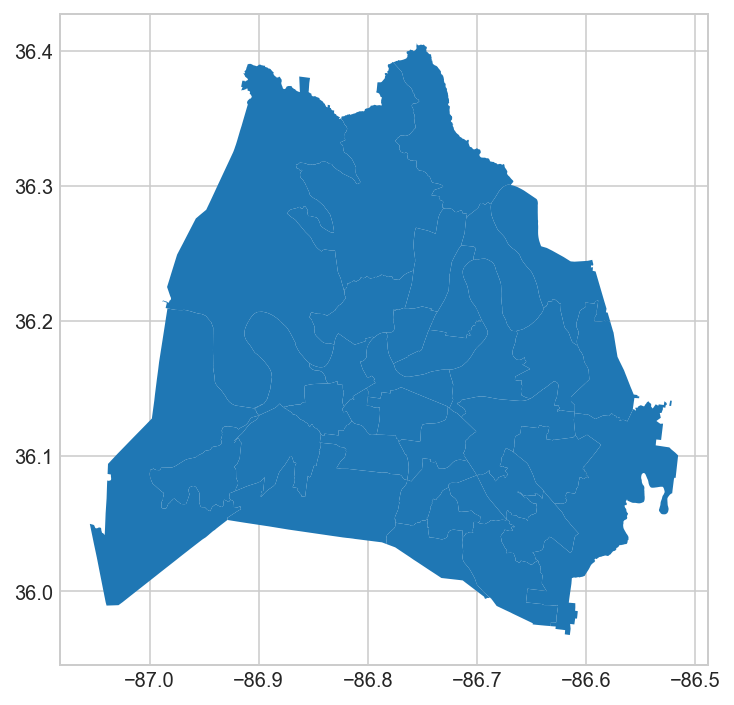

In [39]:
poly.plot();

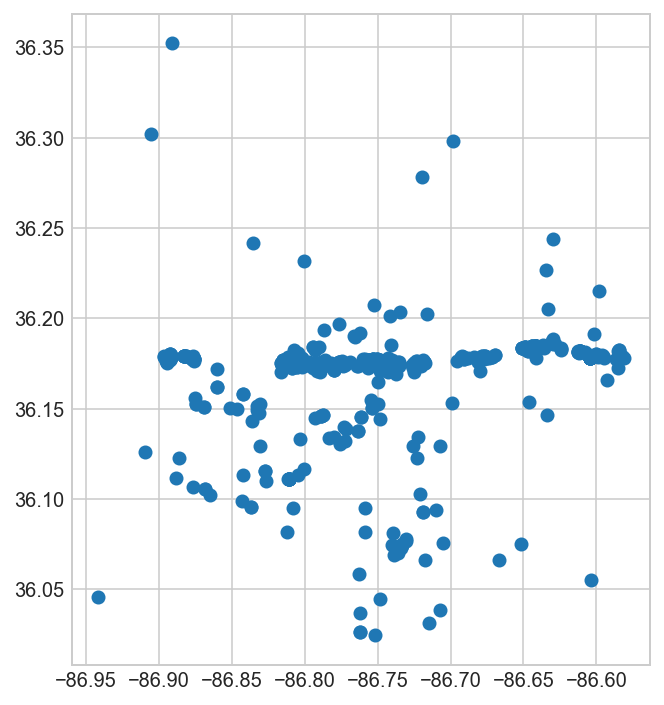

In [40]:
point.plot();

Now we're going to join the two to see what points are in each council district.  
To construct the join, keep in mind that we want to find the points within the district polygons, so the geometry for the new (combined) GeoDataFrame comes from poly.

In [41]:
pointsbydist = gpd.sjoin(point, poly, op='within')

In [42]:
pointsbydist.head(3)

dist_left                                     type                  subtype  \
0        26  Building Residential Rehab Storm Damage  Single Family Residence   
2        26        Building Residential - Foundation  Single Family Residence   
3        26  Building Residential Rehab Storm Damage  Single Family Residence   

                      date   cost                 address  \
0  2021-06-21T00:00:00.000  40000          5045  SUTER DR   
2  2021-09-17T00:00:00.000  30000         4818  MILNER DR   
3  2021-06-21T00:00:00.000  89000  224  ELYSIAN FIELDS RD   

                                             purpose        lat         lon  \
0  to conduct general repairs to existing residen...  36.068916  -86.738966   
2  to rehab and elevate flood damaged foundation ...  36.074775  -86.733314   
3  Replace floors, replace hvac and ductwork, rep...  36.092995   -86.71886   

                     geometry  permit_count_left  index_right  \
0  POINT (-86.73897 36.06892)                  1           21   
2  POINT (-86.73331 36.07478)                  1           21   
3  POINT (-86.71886 36.09300)                  1           21   

   permit_count_right dist_right  id  
0                18.0         26  21  
2                18.0         26  21  
3                18.0         26  21

In [43]:
pointsbydist.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 726 entries, 0 to 729
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   dist_left           726 non-null    object  
 1   type                726 non-null    object  
 2   subtype             726 non-null    object  
 3   date                726 non-null    object  
 4   cost                726 non-null    object  
 5   address             726 non-null    object  
 6   purpose             726 non-null    object  
 7   lat                 726 non-null    object  
 8   lon                 726 non-null    object  
 9   geometry            726 non-null    geometry
 10  permit_count_left   726 non-null    int64   
 11  index_right         726 non-null    int64   
 12  permit_count_right  725 non-null    float64 
 13  dist_right          725 non-null    object  
 14  id                  726 non-null    object  
dtypes: float64(1), geometry(1), int6

We can drop some stuff, like the points by district for example and the double columns.

In [44]:
pointsbydist = pointsbydist.drop(columns = ['permit_count_left', 'permit_count_right', 'index_right', 'dist_right'])

In [45]:
pointsbydist = pointsbydist.rename(columns = {'dist_left':'dist'})

In [46]:
pointsbydist.head(3)

dist                                     type                  subtype  \
0   26  Building Residential Rehab Storm Damage  Single Family Residence   
2   26        Building Residential - Foundation  Single Family Residence   
3   26  Building Residential Rehab Storm Damage  Single Family Residence   

                      date   cost                 address  \
0  2021-06-21T00:00:00.000  40000          5045  SUTER DR   
2  2021-09-17T00:00:00.000  30000         4818  MILNER DR   
3  2021-06-21T00:00:00.000  89000  224  ELYSIAN FIELDS RD   

                                             purpose        lat         lon  \
0  to conduct general repairs to existing residen...  36.068916  -86.738966   
2  to rehab and elevate flood damaged foundation ...  36.074775  -86.733314   
3  Replace floors, replace hvac and ductwork, rep...  36.092995   -86.71886   

                     geometry  id  
0  POINT (-86.73897 36.06892)  21  
2  POINT (-86.73331 36.07478)  21  
3  POINT (-86.71886 36.09300)  21

Count the permits issued in each council district

In [47]:
pointsbydist['dist'].value_counts()

6     220
14     94
19     90
21     84
20     47
15     35
12     31
5      27
26     18
25     17
17     11
24      8
23      6
4       6
34      4
16      4
2       3
1       3
11      3
35      2
28      2
30      2
13      2
7       2
8       1
10      1
33      1
31      1
18      1
Name: dist, dtype: int64

In [48]:
pointsbydist['type'].value_counts()

Building Residential Rehab Storm Damage    249
Building Commercial Rehab Storm Damage     143
Building Demolition Storm Damage            92
Building Residential New Storm Damage       86
Building Residential - New                  52
Building Commercial New Storm Damage        39
Building Residential - Rehab                15
Building Demolition Permit                  15
Building Residential - Addition             10
Building Commercial - Rehab                  7
Building Residential - Foundation            5
Building Commercial - Roofing / Siding       5
Building Sign Permit                         3
Building Use & Occupancy                     2
Building Residential - Fire Damage           1
Building Residential - Roofing / Siding      1
Building Commercial - Shell                  1
Name: type, dtype: int64

In [49]:
#basemap (used state cap. for the lat/long)
base = folium.Map(location = [36.165096, -86.783637], zoom_start = 11, control_scale = True)

#create cluster with applications
marker_cluster = MarkerCluster(name = 'Permits Issued')

for row_index, row_values in pointsbydist.iterrows():
        loc = row_values['lat'], row_values['lon']
        pop = str(row_values['type'])
        icon = folium.Icon(color = 'red', prefix = 'fa')
        marker = folium.Marker(location = loc,
                              popup = pop,
                              icon = icon)
        marker.add_to(marker_cluster)
        
#choropleth of counts by district
chor = folium.Choropleth(geo_data = poly, 
                 name = 'Permits by District', 
                 data = issuedbydist, 
                 columns = ['id', 'permit_count'], 
                 key_on = 'feature.id', 
                 fill_color = 'YlOrRd', 
                 fill_opacity = 0.8, 
                 line_opacity = 0.2, 
                 line_color = 'black', 
                 line_weight = 1, 
                 highlight = True, 
                 nan_fill_color = 'white', 
                 show = True, 
                 overlay = True, 
                 smooth_factor = 1.0, 
                 legend_name = 'Permit Count')

# Add hover functionality.
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
hover = folium.features.GeoJson(data = poly,
                                style_function=style_function, 
                                control=False,
                                highlight_function=highlight_function, 
                                tooltip=folium.features.GeoJsonTooltip(fields=['dist', 'permit_count'],
                                                                       aliases=['Council District', 'Permit Count'],
                                                                       style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") ))
base.add_child(marker_cluster)
base.add_child(chor)
base.add_child(hover)
base.keep_in_front(hover)

base

It looks like most of the permits were pulled in district 6. This is in line with local knowledge about the 2020 tornado and more recent storms hitting East Nashville. We're going to isolate the district from each of our geo files and create its own map.

In [50]:
dist6points = pointsbydist.loc[pointsbydist['dist'] == '6']
dist6points.shape

(220, 11)

In [51]:
polygon6 = poly.loc[poly['dist'] =='6']
polygon6.shape

(1, 4)

Plot 'em together real quick

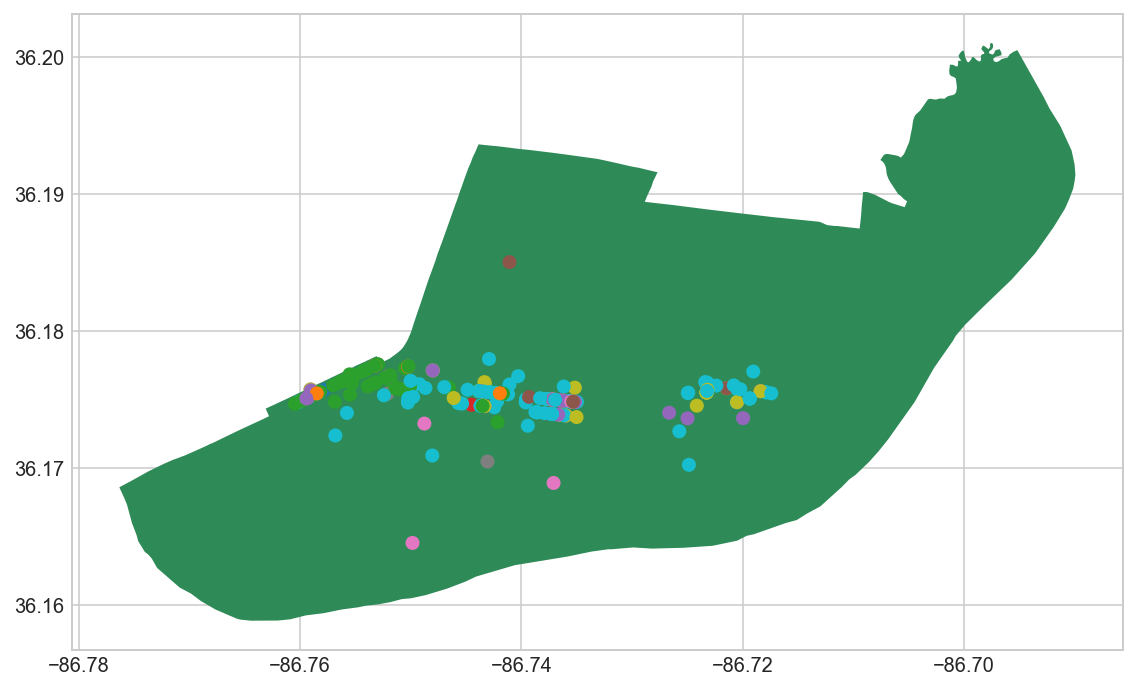

In [52]:
ax = polygon6.plot(figsize = (8, 10), color = 'seagreen')
dist6points.plot(ax=ax, column = 'type'); #vary color by the permit type
plt.show();

Add streets - first we'll need to add a centroid because adding streets takes a center.

In [53]:
center = polygon6.geometry.centroid
print(center)

5    POINT (-86.73145 36.17707)
dtype: geometry


We need this point to be an array with latitude first, but `shapely` points have longitude first. 

In [54]:
area_center = [center.y, center.x]
# check the order of area_center, the location for our folium map
print(area_center)

[5    36.177073
dtype: float64, 5   -86.731454
dtype: float64]


In [55]:
d6 = folium.Map(location= area_center, zoom_start = 13.5)

#polygon
polygon = folium.GeoJson(polygon6)

#create cluster with applications
marker_cluster = MarkerCluster(name = 'Permits Issued')

for row_index, row_values in dist6points.iterrows():
        loc = row_values['lat'], row_values['lon']
        pop = str(row_values['type'])
        icon = folium.Icon(color = 'red', prefix = 'fa')
        marker = folium.Marker(location = loc,
                              popup = pop,
                              icon = icon)
        marker.add_to(marker_cluster)

d6.add_child(polygon)
d6.add_child(marker_cluster)

d6

In [56]:
dist6points['type'].value_counts()

Building Residential Rehab Storm Damage    88
Building Commercial Rehab Storm Damage     47
Building Residential New Storm Damage      33
Building Demolition Storm Damage           29
Building Commercial New Storm Damage        6
Building Residential - Addition             5
Building Residential - New                  4
Building Residential - Rehab                3
Building Demolition Permit                  2
Building Commercial - Roofing / Siding      2
Building Sign Permit                        1
Name: type, dtype: int64

We're seeing that the most permits were for residential rehab storm damage followed by commercial rehab.

In [57]:
dist6points['subtype'].value_counts()

Single Family Residence                     103
Demolition Permit - Residential              25
Retail, Department / Retail Stores           16
Duplex                                       12
General Office, Professional Services        10
Multifamily, Townhome                         7
Demolition Permit - Commercial                7
Accessory Structure, Garage                   6
Multifamily, Condominium 3&4 Unit Bldg        6
Restaurant (Full Service)                     4
Multifamily, Apt / Twnhome > 5 Unit Bldg      3
Religious Institution, Worship Space          3
Detached Accessory Dwelling Unit              2
Accessory Structure, Carport                  2
Sign - Ground /  Wall Signs                   1
Personal Care Svcs,  Fitness Studio           1
Restaurant (Fast Food)                        1
General Office, Courtrooms                    1
Religious Institution, Fellowship Hall        1
Religious Institution, Auditorium             1
Warehouse, Storage S-1                  

In [58]:
dist6points['date'].value_counts()

2020-05-28T00:00:00.000    8
2020-04-03T00:00:00.000    6
2020-04-29T00:00:00.000    5
2020-06-09T00:00:00.000    5
2020-04-10T00:00:00.000    4
                          ..
2021-03-25T00:00:00.000    1
2020-05-13T00:00:00.000    1
2020-03-27T00:00:00.000    1
2020-08-03T00:00:00.000    1
2021-04-14T00:00:00.000    1
Name: date, Length: 135, dtype: int64

We see that maximum 8 permits were pulled on the same day over all 135 pulled in the district for storm damage over the course of 3 years. Combine this with our knowledge of one large storm in 2020 and I'm coming to the conclusion that we should do a time series analysis and see what sorts of trends there are that can tell us about seasonality as well as delay in permitting from major weather events. Prep a regular dataframe and export as a csv to bring into another document.

In [59]:
districtsix = dist6points.drop(columns = ['geometry', 'id'],)
districtsix = pd.DataFrame(districtsix)
districtsix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 6 to 719
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dist     220 non-null    object
 1   type     220 non-null    object
 2   subtype  220 non-null    object
 3   date     220 non-null    object
 4   cost     220 non-null    object
 5   address  220 non-null    object
 6   purpose  220 non-null    object
 7   lat      220 non-null    object
 8   lon      220 non-null    object
dtypes: object(9)
memory usage: 17.2+ KB


In [61]:
districtsix.to_csv('../data/districtsix.csv', index = False)

In [67]:
stormpermits = pointsbydist.drop(columns = ['geometry', 'id', 'lat', 'lon','dist', 'type','subtype','cost','address','purpose'])
stormpermits['summer'] = 1
stormpermits = pd.DataFrame(stormpermits)
stormpermits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 0 to 729
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    726 non-null    object
 1   summer  726 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 17.0+ KB


In [68]:
stormpermits.to_csv('../data/stormpermits.csv', index = False)